In [137]:
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
from scipy import integrate

In [138]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [139]:
lats = np.linspace(90, -90, 145)
lons = np.linspace(0, 358.75, 288)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300,
          350, 400, 450, 500, 550, 600, 650, 700,
          750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

In [140]:
ps_ds = xr.open_mfdataset('raw_monthly_data/anl_surf*.nc')

ps_ds = ps_ds.rename({'initial_time0_hours':'time',
                'g0_lat_1':'lat',
                'g0_lon_2':'lon',
                'PRES_GDS0_SFC_S123':'pres_surf'})

ps_ds = ps_ds.drop(['initial_time0','initial_time0_encoded'])

ps_ds

<xarray.Dataset>
Dimensions:    (time: 516, lat: 145, lon: 288)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * lat        (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    pres_surf  (time, lat, lon) float32 dask.array<chunksize=(12, 145, 288), meta=np.ndarray>
Attributes:
    creation_date:  Mon Oct 10 15:42:18 MDT 2022
    NCL_Version:    6.6.2
    system:         Linux casper34 3.10.0-1127.18.2.el7.x86_64 #1 SMP Sun Jul...
    Conventions:    None
    grib_source:    anl_surf125.001_pres.197901_197912.cox592632.grb
    title:          NCL: convert-GRIB-to-netCDF

In [141]:
#First get the weights

levels_array = np.array(levels)#[::-1]) #NOTE: WE flip the level array here
mlev = (levels_array[:-1] + levels_array[1:]) / 2
new_mlev = np.append(np.insert(mlev, 0, 0), 1000)
#Now we have the generic edges of our level boxes

WEIGHT = np.empty((len(levels), len(lats), len(lons)))
ps = ps_ds.pres_surf.mean('time').values / 100 #To get in hPa

for i in range(len(lats)):
    for j in range(len(lons)):
        
        #This looks and first makes sure that the level at each point is not below the surface pressure
        #If a point is below ths surface pressure, it gets converted to the surface pressure
        #Then we subtract out the original neighboring levels
        #This will result in some level boxes getting negative weight (where surface pressure was used)
        #So, we change those values to 0
        #Then we deal with converting hPa to Pa and making units work with g
        WEIGHT[:,i,j] = np.maximum(np.minimum(new_mlev[1:], ps[i,j] * np.ones(len(levels))) - new_mlev[:-1],
                                   np.zeros(len(levels))) * 100 / g

#This is our generic weighting, used later
weight = -(new_mlev[:-1] - new_mlev[1:]) * 100 / g

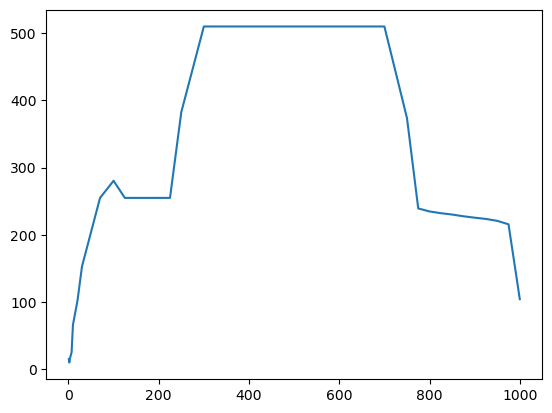

In [142]:
plt.plot(levels, np.nanmean(WEIGHT[:,10,:], axis=1))

plt.show()

In [143]:
#This is basically just making a topography maks

tmask = np.ones((len(levels), len(lats), len(lons)))
TMASK = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        lon_idxs = np.where(ps[j,:] < new_mlev[i+1])

        tmask[i,j,lon_idxs] = 0
        TMASK[i,j,lon_idxs] = np.nan

### Decide on partial levels below

In [144]:
#WEIGHT = WEIGHT * tmask

In [145]:
#This is the weighting for each point, allowing for us to take zonal averages more easily

ZON_NORM = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        ZON_NORM[i,j,:] = WEIGHT[i,j,:] / np.maximum(np.sum(WEIGHT[i,j,:]), 1e-5)

In [146]:
#And zonal weights, useful for AHT where we have zonal-mean quantities

ZON_WEIGHT = np.ones((len(levels), len(lats)))

for i in range(len(levels)):
    ZON_WEIGHT[i,:] = np.mean(WEIGHT[i,:,:], axis=1)

### Now, let's save out all the weighting info to a netcdf

In [147]:
WEIGHT_attrs = 'Weighting for each grid cell. Not normalized.'
weight_attrs = 'Generic weighting for the column. Does not account for surface pressure.'
TMASK_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or nan if below. Unitless.'
tmask_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or 0 if below. Unitless.'
ZON_NORM_attrs = 'Basically a normalized version of WEIGHT, where the normalization is over longitude. To take a zonal average, multiply a quantity by this and sum along the longitude dimenion. Unitless.'
ZON_WEIGHT_attrs = 'Zonal average weight.'

weighting_ds = xr.Dataset(
                    data_vars = dict(
                        WEIGHT=(['level','latitude','longitude'], WEIGHT, {'Description':WEIGHT_attrs, 'units':'kg/m^2'}),
                        weight=(['level'], weight, {'Description':weight_attrs, 'units':'kg/m^2'}),
                        TMASK=(['level','latitude','longitude'], TMASK, {'Description':TMASK_attrs, 'units':'Unitless'}),
                        tmask=(['level','latitude','longitude'], tmask, {'Description':tmask_attrs, 'units':'Unitless'}),
                        ZON_NORM=(['level','latitude','longitude'], ZON_NORM, {'Description':ZON_NORM_attrs, 'units':'Unitless'}),
                        ZON_WEIGHT=(['level','latitude'], ZON_WEIGHT, {'Description':ZON_WEIGHT_attrs, 'units':'kg/m^2'}),
                    ),
                    coords=dict(
                        level=levels[::-1],
                        latitude=lats,
                        longitude=lons)
)

#weighting_ds.to_netcdf('jra_aht_weights.nc')

### Load in the data

In [148]:
jra_data = xr.open_mfdataset('raw_monthly_data/jra_*.nc')

In [149]:
jra_data

,Array,Chunk
Bytes,3.04 GiB,5.89 MiB
Shape,"(528, 37, 145, 288)","(1, 37, 145, 288)"
Count,1584 Tasks,528 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.04 GiB,5.89 MiB
Shape,"(528, 37, 145, 288)","(1, 37, 145, 288)"
Count,1584 Tasks,528 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [40]:
import numpy as np
from metpy.calc import thickness_hydrostatic
from metpy.units import units
from metpy.constants import earth_gravity, dry_air_gas_constant

def wmo(pFull, TFull, lapseC=2.0*units("K/km"), height=False):
    """
    Implements NCAR's Fortran code in python:
        https://github.com/NCAR/ncl/blob/develop/ni/src/lib/nfpfort/stattrop_dp.f
    """

    nLev = pFull.size
    nLevm = nLev-1

    pMin = 85.0*units.mbar
    pMax = 450.0*units.mbar

    dZ = 2000.0*units.meters

    g = earth_gravity
    R = dry_air_gas_constant

    const = g/R

    found = False

    lapse = np.zeros(nLevm)*units.kelvin/units.km
    pHalf = np.zeros(nLevm)*units.mbar
    pTrop = 0*units.mbar
    for iLev in range(0, nLevm):
        lapse[iLev] = const*np.log(TFull[iLev]/TFull[iLev+1])/np.log(pFull[iLev]/pFull[iLev+1])
        pHalf[iLev] = (pFull[iLev]+pFull[iLev+1])*0.5

    for iLev in range(0,nLevm-1):
        if lapse[iLev] < lapseC and pFull[iLev] < pMax and not found:
            P1 = np.log(pHalf[iLev].magnitude)
            P2 = np.log(pHalf[iLev+1].magnitude)
            if (lapse[iLev] != lapse[iLev+1]):
                weight = (lapseC-lapse[iLev])/(lapse[iLev+1]-lapse[iLev])
                #tropopause pressure
                pTrop = np.exp(P1+weight*(P2-P1))*units.mbar
            else:
                pTrop = pHalf[iLev]

            p2km = pTrop*np.exp(-dZ*const/TFull[iLev])
            lapseAvg = 0
            lapseSum = 0
            kount = 0
            for L in range (iLev,nLevm):
                if pHalf[L] > p2km:
                    lapseAvg = lapseSum + lapse[L]
                    kount = kount + 1
                    lapseAvg = lapseSum/kount
            found = lapseAvg < lapseC
            if not found:
                print ("Tropopause not found")
            else:
                iTrop = iLev
                pTrop = pMin if pTrop < pMin else pTrop

    if height:
        z = thickness_hydrostatic(pFull[0:iTrop],TFull[0:iTrop])
        return z.to(units.km)

    return pTrop.to(units.mbar)

In [203]:
trop_test = np.zeros(len(lats))

for i in range(len(lats)):

    trop_test[i] = wmo(np.array(levels)[::-1]*units.hPa,
                       jra_data_monthly_temps_zon_mean.isel(lat=i).isel(month=0).values[::-1]*units.K).magnitude


/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/pint/numpy_func.py:303: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/pint/quantity.py:1309: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


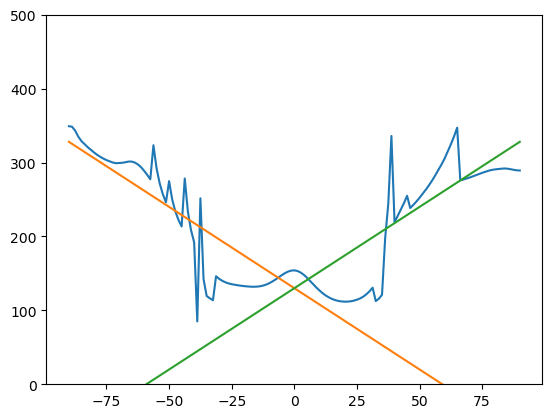

In [193]:
#trop_test[trop_test>400] = np.nan

plt.plot(lats, trop_test)

plt.plot(lats, 130 + (-2.2 * lats))
plt.plot(lats, 130 + (2.2 * lats))

plt.ylim([0, 500])
plt.show()

int1 = [130, 130, 130, 130, 130, 150, 150, 150, 130, 130, 130, 130]
int2 = [130, 130, 130, 130, 130, 150, 150, 150, 130, 130, 130, 130]

slope1 = [-3, -2.8, -2.6, -2.6, -2.3, -1.5, -1.5, -1.5, -1.5, -1.5, -2, -2.2]
slope2 = [1.7, 2, 2.4, 2.4, 2.4, 2.4, 2, 2, 2, 2.2, 2.2, 2.2]

#Jan
130 + -3lats
130 + 1.7lats

#Feb
130 + -2.8lats
130 + 2 lats

#Mar
130 + -2.6lats
130 + 2.4 lats

#Apr
130 + -2.6lats
130 + 2.4 lats

#May
130 + -2.3lats
130 + 2.4 lats

june
150 + -1.5lats
150 + 2lats

july
150 + -1.5lats
150 + 2lats

aug
150 + -1.5lats
150 + 2lats

sep
130 + -1.5lats
130 + 2lats

oct
130 + -1.5lats
130 + 2.2lats

nov
130 + -2lats
130 + 2.2lats

dec
130 + -2.2lats
130 + 2.2lats

100.0


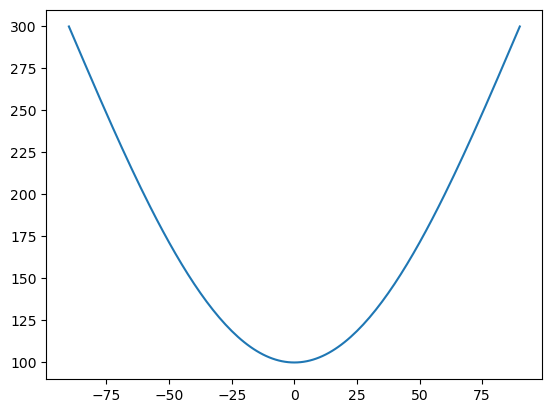

In [277]:
plt.plot(lats, 300 -  200 * np.cos(np.deg2rad(lats)))

print(np.amin(300 -  200 * np.cos(np.deg2rad(lats))))
plt.show()

In [278]:
trop_mask = np.zeros((len(levels), len(lats)))

for i in range(len(lats)):
    
    neg_cut = 130 + (-3 * lats[i])
    pos_cut = 160 + (1.7 * lats[i])
    
    cut = 300 -  200 * np.cos(np.deg2rad(lats[i]))
    
    for j in range(len(levels)):
        
        if levels[j] > cut:
            trop_mask[j,i] =1
        else:
            trop_mask[j,i] = 0
        
        #if levels[j] > neg_cut and levels[j] > pos_cut:
            #trop_mask[j,i] =1
        #else:
            #trop_mask[j,i] = 0

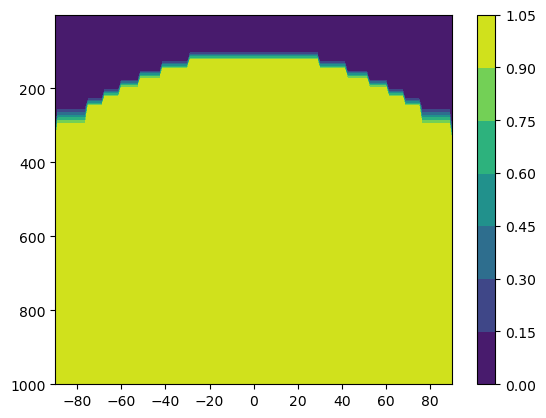

In [279]:
plt.contourf(lats, levels, trop_mask)

plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [70]:
jra_data_monthly_temps = jra_data.temp.groupby('time.month').mean('time').compute()

In [29]:
jra_data_monthly_temps_zon_mean = np.sum(jra_data_monthly_temps * ZON_NORM[None,:,:,:], axis=3).compute()

In [30]:
mean_grad = jra_data_monthly_temps_zon_mean.mean('month').differentiate('lev').compute()

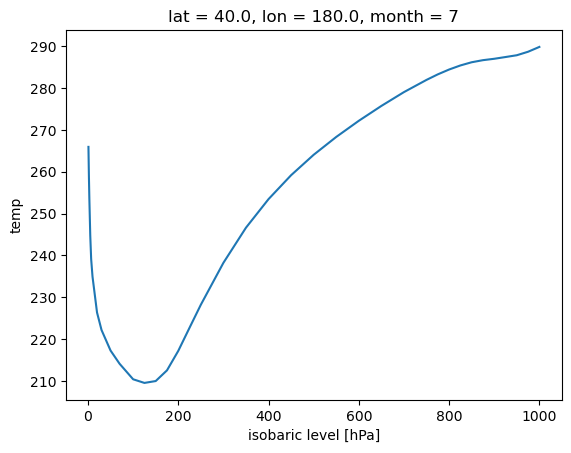

In [38]:
jra_data_monthly_temps.sel(lat=40, lon=180).isel(month=6).plot()

plt.show()

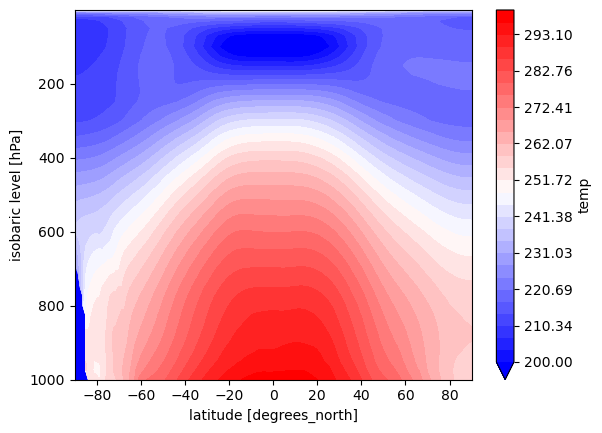

In [39]:
jra_data_monthly_temps_zon_mean.mean('month').plot.contourf(levels=np.linspace(200, 300, 30), cmap='bwr')

plt.gca().invert_yaxis()
plt.show()

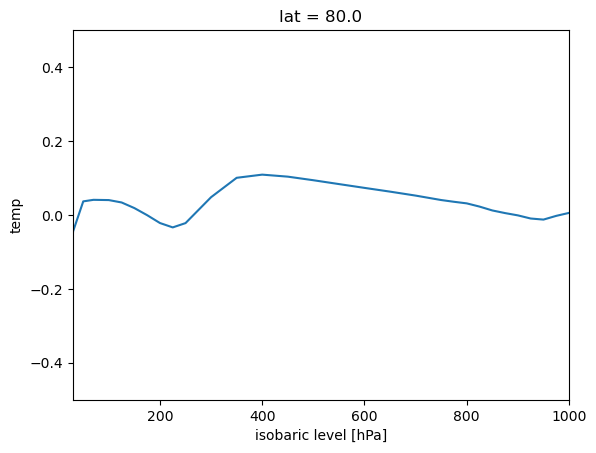

In [27]:
mean_grad.sel(lat=80).plot()

plt.xlim([30, 1000])
plt.ylim([-.5, .5])
plt.show()

### Make troposphere mask

In [ ]:
#Original way

In [201]:
int1 = [130, 130, 130, 130, 130, 150, 150, 150, 130, 130, 130, 130]
int2 = [130, 130, 130, 130, 130, 150, 150, 150, 130, 130, 130, 130]

slope1 = [-3, -2.8, -2.6, -2.6, -2.3, -1.5, -1.5, -1.5, -1.5, -1.5, -2, -2.2]
slope2 = [1.7, 2, 2.4, 2.4, 2.4, 2.4, 2, 2, 2, 2.2, 2.2, 2.2]

trop_mask_list = []
strat_mask_list = []

for k in range(12):
    trop_mask = np.zeros((len(levels), len(lats)))
    strat_mask = np.zeros((len(levels), len(lats)))
    
        
    for i in range(len(lats)):
        
        neg_cut = int1[k] + (slope1[k] * lats[i])
        pos_cut = int2[k] + (slope2[k] * lats[i])

        for j in range(len(levels)):

            if levels[j] >= neg_cut and levels[j] >= pos_cut:
                trop_mask[j,i] =1
                strat_mask[j,i] = 0
            elif levels[j] < neg_cut and levels[j] < pos_cut:
                trop_mask[j,i] = 0
                strat_mask[j,i] = 1
            elif levels[j] < neg_cut or levels[j] < pos_cut:
                strat_mask[j,i] = 1
    trop_mask_list.append(trop_mask)
    strat_mask_list.append(strat_mask)

In [ ]:
#Way following Pendergrass et al., 2017

In [150]:

trop_mask_list = []
strat_mask_list = []

for k in range(12):
    trop_mask = np.zeros((len(levels), len(lats)))
    strat_mask = np.zeros((len(levels), len(lats)))
    
        
    for i in range(len(lats)):
        
        cut = 300 -  200 * np.cos(np.deg2rad(lats[i]))

        for j in range(len(levels)):

            if levels[j] > cut:
                trop_mask[j,i] =1
                strat_mask[j,i] = 0
            elif levels[j] <= cut:
                trop_mask[j,i] = 0
                strat_mask[j,i] = 1
    trop_mask_list.append(trop_mask)
    strat_mask_list.append(strat_mask)

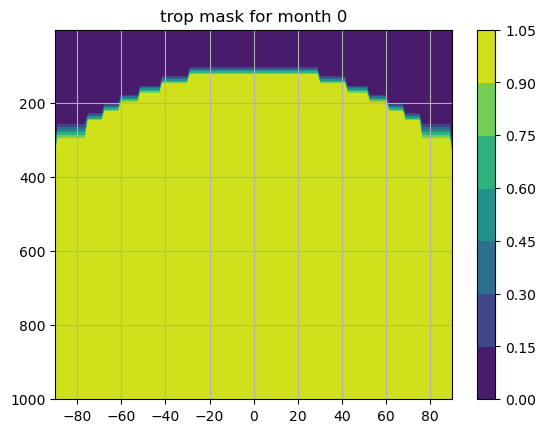

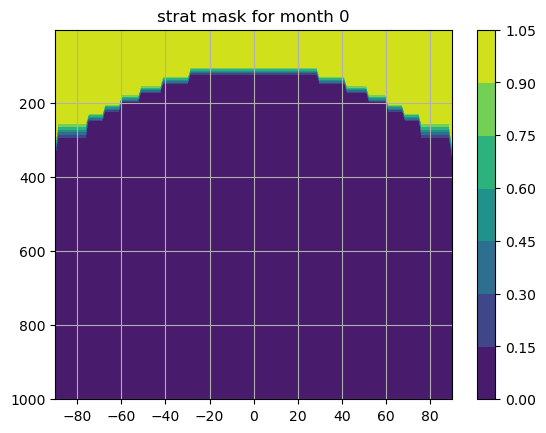

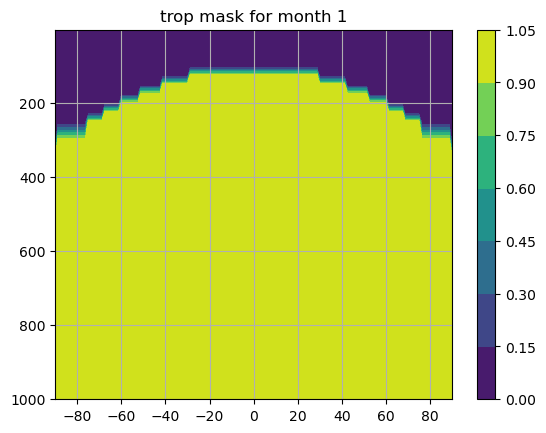

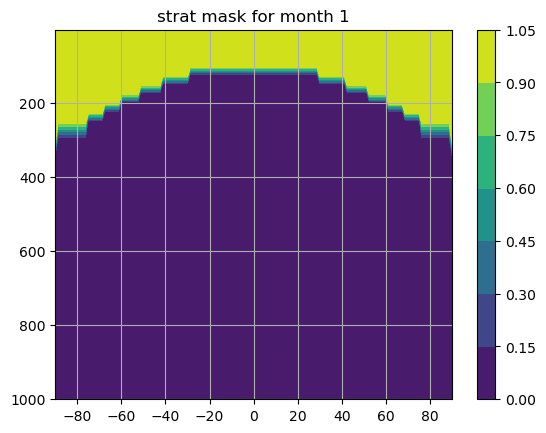

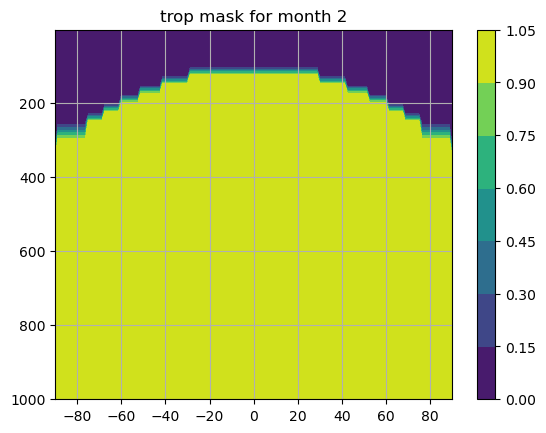

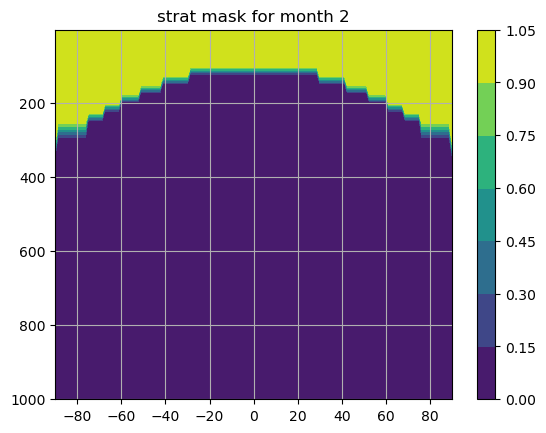

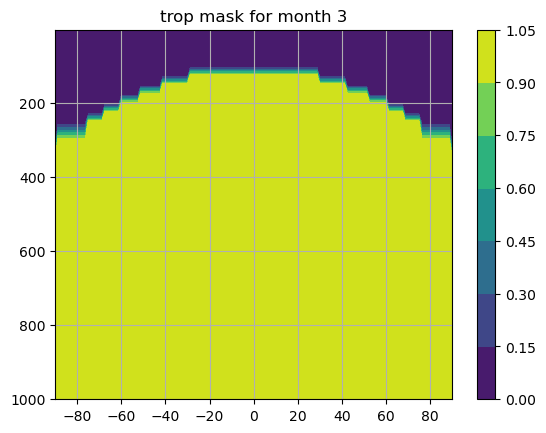

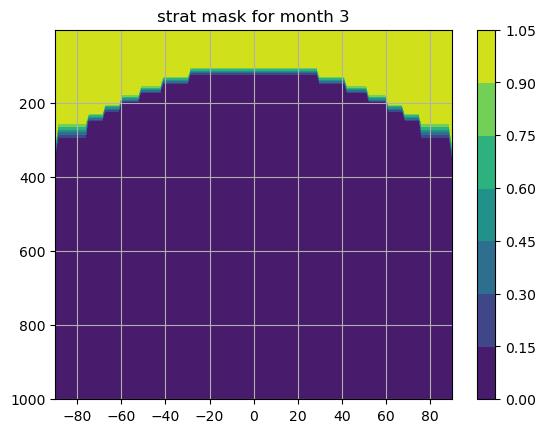

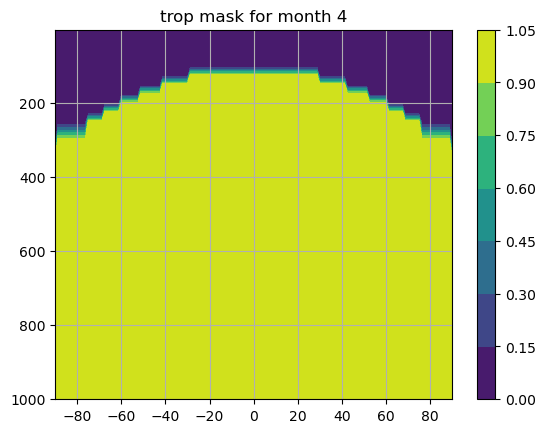

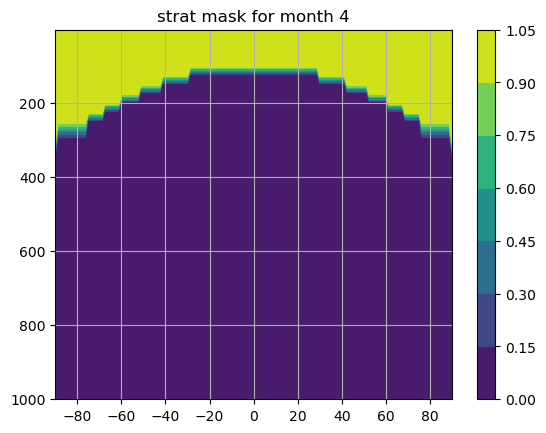

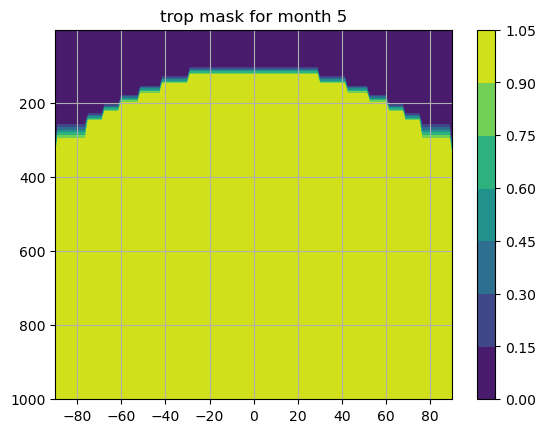

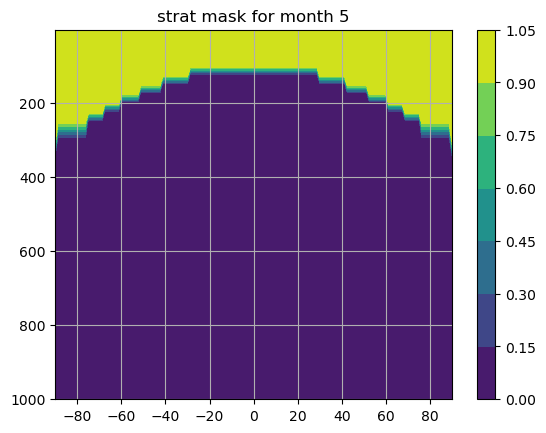

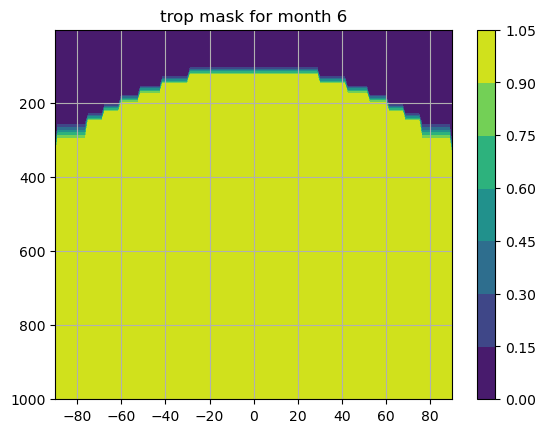

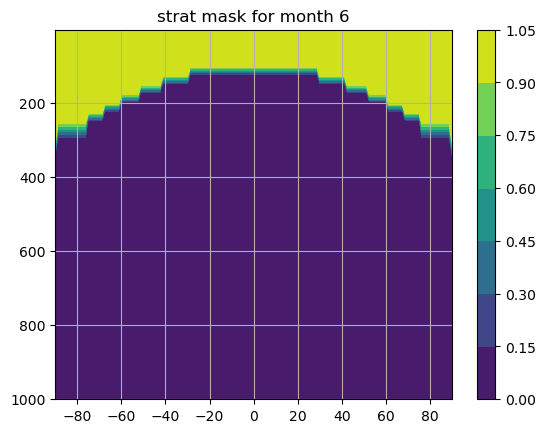

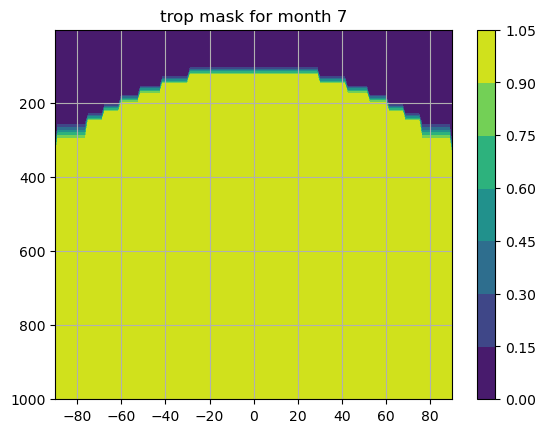

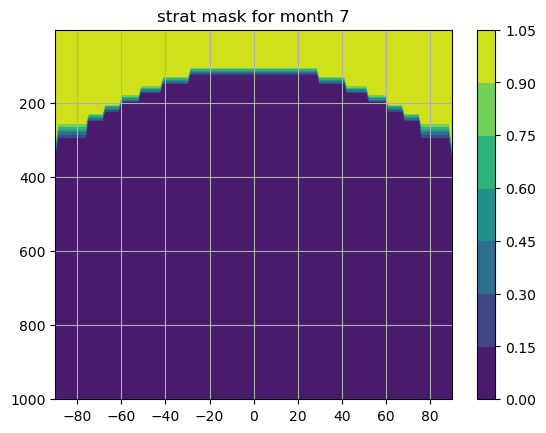

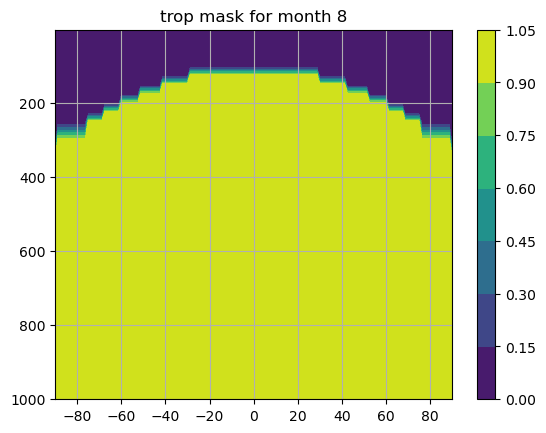

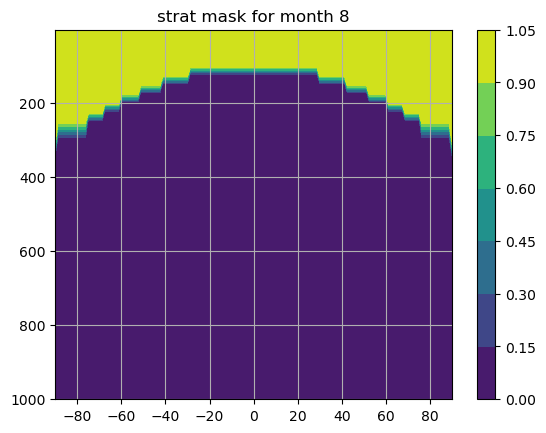

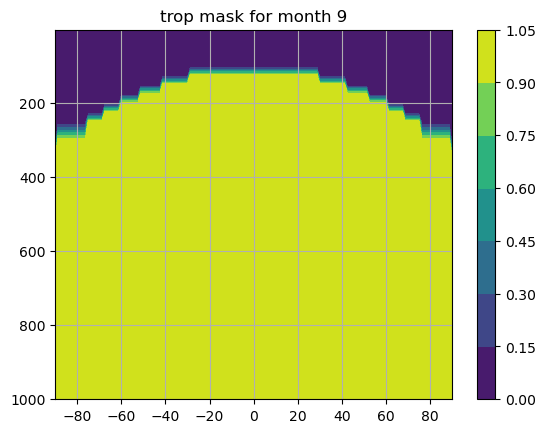

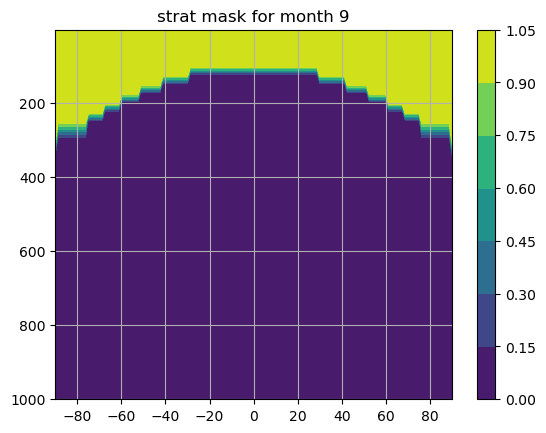

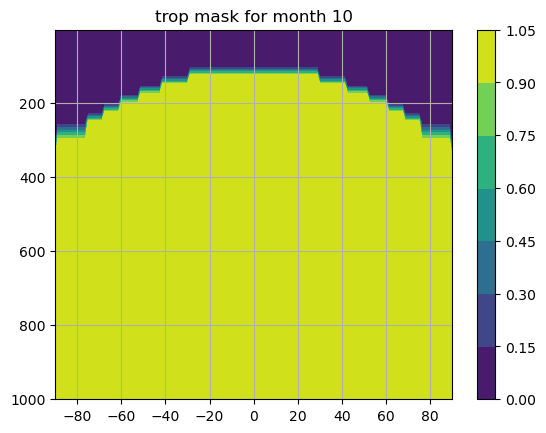

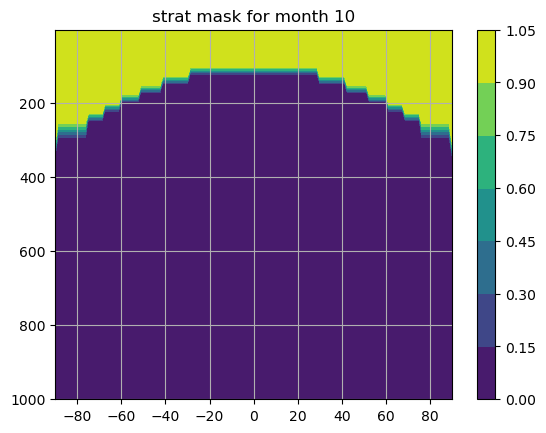

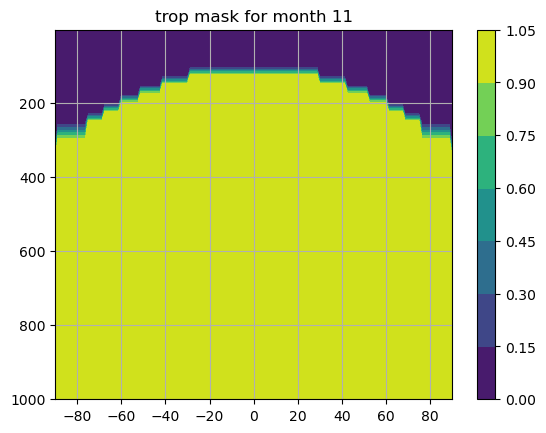

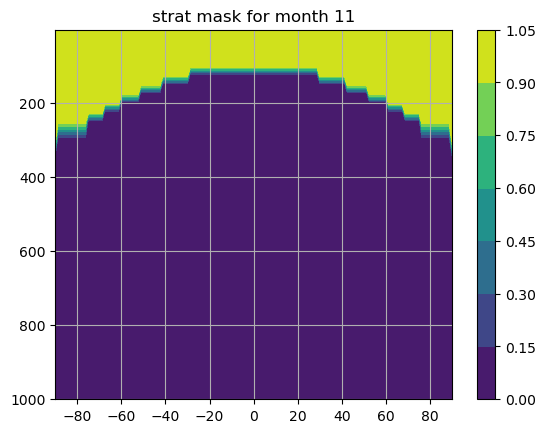

In [151]:
trop_masks = np.stack(trop_mask_list)
strat_masks = np.stack(strat_mask_list)

for i in range(12):
    
    plt.contourf(lats, levels, trop_masks[i])
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.grid()
    plt.title(f'trop mask for month {i}')
    plt.show()
    
    plt.contourf(lats, levels, strat_masks[i])
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(f'strat mask for month {i}')
    plt.grid()
    plt.show()

### Now calculate AHT

In [152]:


def aht_jra(time_idx, correct_mass=True):
    
    month_idx = time_idx % 12
    trop_mask = trop_masks[month_idx]
    strat_mask = strat_masks[month_idx]
    
    WEIGHT_copy = copy.deepcopy(WEIGHT)
    
    #Load in the data and flip the level dimension, since we did this for the weighting too
    v = jra_data.vcomp.isel(time=time_idx).values#[::-1, :, :]
    t = jra_data.temp.isel(time=time_idx).values#[::-1, :, :]
    q = jra_data.q.isel(time=time_idx).values#[::-1, :, :]
    z = jra_data.height.isel(time=time_idx).values#[::-1, :, :]
    
    vt = jra_data.vt.isel(time=time_idx).values#[::-1, :, :]
    vq = jra_data.vq.isel(time=time_idx).values#[::-1, :, :]
    vz = jra_data.vz.isel(time=time_idx).values#[::-1, :, :]
    
    #For some reason, first 10 vertical levels of q are always nan
    #Effectively water vapor that high is 0 anyways, so let's just turn them to 0
    
    q[:10,:,:] = 0
    

    #Now get rid of nans everywhere
    WEIGHT_copy[np.isnan(v)] = 0
    WEIGHT_copy[np.isnan(t)] = 0
    WEIGHT_copy[np.isnan(q)] = 0
    WEIGHT_copy[np.isnan(z)] = 0

    v[np.isnan(v)] = 0
    t[np.isnan(t)] = 0
    q[np.isnan(q)] = 0
    z[np.isnan(z)] = 0
    vt[np.isnan(vt)] = 0
    vq[np.isnan(vq)] = 0
    vz[np.isnan(vz)] = 0

    #Convert everything to the same MSE units
    SE = cp * t
    PE = g * z
    ME = L * q
    MSE = SE + PE + ME
    
    #Find zonal-averages
    SE_bar = np.sum(ZON_NORM * SE, axis=2)
    ME_bar = np.sum(ZON_NORM * ME, axis=2)
    PE_bar = np.sum(ZON_NORM * PE, axis=2)
    V_bar = np.sum(ZON_NORM * v, axis=2)
    E_bar = np.sum(ZON_NORM * MSE, axis=2)

    #Then find zonal anomalies
    Ve = v - V_bar[:,:,None]
    SEe = SE - SE_bar[:,:,None]
    MEe = ME - ME_bar[:,:,None]
    PEe = PE - PE_bar[:,:,None]
    
    #Multiply zonal-anomalies to get the SE piece
    #_map is just referring to plan view, ie before zonal averaging occurs
    #Dividing the WEIGHT by weight, normalizes things
    VSEse_map = (Ve * SEe) * (WEIGHT_copy / weight[:,None,None])
    VMEse_map = (Ve * MEe) * (WEIGHT_copy / weight[:,None,None])
    VPEse_map = (Ve * PEe) * (WEIGHT_copy / weight[:,None,None])
    
    #Get the SEs
    VSEse_bar = np.mean(VSEse_map, axis=2)
    VMEse_bar = np.mean(VMEse_map, axis=2)
    VPEse_bar = np.mean(VPEse_map, axis=2)
    
    #Now do the TEs
    #So, follow same formula as SEs     
    VSEte_map = ((vt * cp) - (v * SE)) * (WEIGHT_copy / weight[:,None,None])
    VMEte_map = ((vq * L) - (v * ME)) * (WEIGHT_copy / weight[:,None,None])
    VPEte_map = ((vz * g) - (v * PE)) * (WEIGHT_copy / weight[:,None,None])

    VSEte_bar = np.mean(VSEte_map, axis=2)
    VMEte_bar = np.mean(VMEte_map, axis=2)
    VPEte_bar = np.mean(VPEte_map, axis=2)
        
    #Account for non-zero mass transport in the MMC by removing the vertically averaged v and MSE
    V_vert_ave = np.sum(V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    E_vert_ave = np.sum(E_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    ME_vert_ave = np.sum(ME_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    PE_vert_ave = np.sum(PE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    SE_vert_ave = np.sum(SE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    
    if correct_mass == True:
        V_bar_new = V_bar - V_vert_ave[None,:]
        E_bar_new = E_bar - E_vert_ave[None,:]
        ME_bar_new = ME_bar - ME_vert_ave[None,:]
        PE_bar_new = PE_bar - PE_vert_ave[None,:]
        SE_bar_new = SE_bar - SE_vert_ave[None,:]
    elif correct_mass == False:
        V_bar_new = V_bar
        E_bar_new = E_bar
        ME_bar_new = ME_bar
        PE_bar_new = PE_bar
        SE_bar_new = SE_bar
    else:
        print('Error with specifying mass correction choice')
        
    MASS = np.sum(ZON_WEIGHT, axis=0) * V_vert_ave * E_vert_ave
    strm_fnct = np.cumsum(ZON_WEIGHT * V_bar_new, axis=0)
    #Now multiply things by the needed weights and sum in the vertical
    #But also split things by tropopause or above
    MMC_trop = np.sum(ZON_WEIGHT * V_bar_new * E_bar_new * trop_mask, axis=0)
    MMC_strat = np.sum(ZON_WEIGHT * V_bar_new * E_bar_new * strat_mask, axis=0)
    MMC_moist_trop = np.sum(ZON_WEIGHT * V_bar_new * ME_bar_new * trop_mask, axis=0)
    MMC_moist_strat = np.sum(ZON_WEIGHT * V_bar_new * ME_bar_new * strat_mask, axis=0)
    MMC_dry_trop = np.sum(ZON_WEIGHT * V_bar_new * SE_bar_new * trop_mask, axis=0)
    MMC_dry_strat = np.sum(ZON_WEIGHT * V_bar_new * SE_bar_new * strat_mask, axis=0)
    MMC_pot_trop = np.sum(ZON_WEIGHT * V_bar_new * PE_bar_new * trop_mask, axis=0)
    MMC_pot_strat = np.sum(ZON_WEIGHT * V_bar_new * PE_bar_new * strat_mask, axis=0)
    
    #SEs and TEs have already accounted for surface orography, so we just use generic weight here
    SE_dry_trop = np.sum(weight[:,None] * VSEse_bar * trop_mask, axis=0)
    SE_dry_strat = np.sum(weight[:,None] * VSEse_bar * strat_mask, axis=0)
    SE_pot_trop = np.sum(weight[:,None] * VPEse_bar * trop_mask, axis=0)
    SE_pot_strat = np.sum(weight[:,None] * VPEse_bar * strat_mask, axis=0)
    SE_moist_trop = np.sum(weight[:,None] * VMEse_bar * trop_mask, axis=0)
    SE_moist_strat = np.sum(weight[:,None] * VMEse_bar * strat_mask, axis=0)
    
    SE_trop = SE_dry_trop + SE_pot_trop + SE_moist_trop
    SE_strat = SE_dry_strat + SE_pot_strat + SE_moist_strat
    
    TE_dry_trop = np.sum(weight[:,None] * VSEte_bar * trop_mask, axis=0)
    TE_dry_strat = np.sum(weight[:,None] * VSEte_bar * strat_mask, axis=0)
    TE_pot_trop = np.sum(weight[:,None] * VPEte_bar * trop_mask, axis=0)
    TE_pot_strat = np.sum(weight[:,None] * VPEte_bar * strat_mask, axis=0)
    TE_moist_trop = np.sum(weight[:,None] * VMEte_bar * trop_mask, axis=0)
    TE_moist_strat = np.sum(weight[:,None] * VMEte_bar * strat_mask, axis=0)
    
    TE_trop = TE_dry_trop + TE_pot_trop + TE_moist_trop
    TE_strat = TE_dry_strat + TE_pot_strat + TE_moist_strat
    
    return MMC_trop, MMC_moist_trop, MMC_dry_trop, MMC_pot_trop, MMC_strat, MMC_moist_strat, MMC_dry_strat, MMC_pot_strat, SE_trop, SE_moist_trop, SE_dry_trop, SE_pot_trop, SE_strat, SE_moist_strat, SE_dry_strat, SE_pot_strat, TE_trop, TE_moist_trop, TE_dry_trop, TE_pot_trop, TE_strat, TE_moist_strat, TE_dry_strat, TE_pot_strat, MASS, strm_fnct, VSEse_bar, VPEse_bar, VMEse_bar, VSEte_bar, VPEte_bar, VMEte_bar, E_bar_new, V_bar_new, SE_bar_new, PE_bar_new, ME_bar_new



In [ ]:
0- MMC_trop
1-MMC_moist_trop
2-MMC_dry_trop
3-MMC_pot_trop
4-MMC_strat
5-MMC_moist_strat
6-MMC_dry_strat
7-MMC_pot_strat
8-SE_trop
9-SE_moist_trop
10-SE_dry_trop
11-SE_pot_trop
12-SE_strat
13-SE_moist_strat
14-SE_dry_strat
15-SE_pot_strat
16-TE_trop
17-TE_moist_trop
18-TE_dry_trop
19-TE_pot_trop
20-TE_strat
21-TE_moist_strat
22-TE_dry_strat
23-TE_pot_strat
24-MASS
25-strm_fnct
26-VSEse_bar
27-VPEse_bar
28-VMEse_bar
29-VSEte_bar
30-VPEte_bar
31-VMEte_bar
32-E_bar_new
33-V_bar_new
34-SE_bar_new
35-PE_bar_new
36-ME_bar_new


In [153]:
num_months = len(jra_data.time)

TEs_trop = np.zeros((num_months, len(lats)))
TEs_moist_trop = np.zeros((num_months, len(lats)))
TEs_dry_trop = np.zeros((num_months, len(lats)))
TEs_pot_trop = np.zeros((num_months, len(lats)))
TEs_strat = np.zeros((num_months, len(lats)))
TEs_moist_strat = np.zeros((num_months, len(lats)))
TEs_dry_strat = np.zeros((num_months, len(lats)))
TEs_pot_strat = np.zeros((num_months, len(lats)))

SEs_trop = np.zeros((num_months, len(lats)))
SEs_moist_trop = np.zeros((num_months, len(lats)))
SEs_dry_trop = np.zeros((num_months, len(lats)))
SEs_pot_trop = np.zeros((num_months, len(lats)))
SEs_strat = np.zeros((num_months, len(lats)))
SEs_moist_strat= np.zeros((num_months, len(lats)))
SEs_dry_strat = np.zeros((num_months, len(lats)))
SEs_pot_strat = np.zeros((num_months, len(lats)))

MMCs_trop = np.zeros((num_months, len(lats)))
MMCs_moist_trop = np.zeros((num_months, len(lats)))
MMCs_dry_trop = np.zeros((num_months, len(lats)))
MMCs_pot_trop = np.zeros((num_months, len(lats)))
MMCs_strat= np.zeros((num_months, len(lats)))
MMCs_moist_strat = np.zeros((num_months, len(lats)))
MMCs_dry_strat = np.zeros((num_months, len(lats)))
MMCs_pot_strat = np.zeros((num_months, len(lats)))

MASSs = np.zeros((num_months, len(lats)))
strm_fncts = np.zeros((num_months, 37, len(lats)))
VSEses = np.zeros((num_months, 37, len(lats)))
VPEses = np.zeros((num_months, 37, len(lats)))
VMEses = np.zeros((num_months, 37, len(lats)))
VSEtes = np.zeros((num_months, 37, len(lats)))
VPEtes = np.zeros((num_months, 37, len(lats)))
VMEtes = np.zeros((num_months, 37, len(lats)))
V_bars = np.zeros((num_months, 37, len(lats)))
E_bars = np.zeros((num_months, 37, len(lats)))
SE_bars = np.zeros((num_months, 37, len(lats)))
PE_bars = np.zeros((num_months, 37, len(lats)))
ME_bars = np.zeros((num_months, 37, len(lats)))

for i in range(num_months):
    values = aht_jra(i)
    MMCs_trop[i,:] = values[0]
    MMCs_moist_trop[i,:] = values[1]
    MMCs_dry_trop[i,:] = values[2]
    MMCs_pot_trop[i,:] = values[3]
    MMCs_strat[i,:] = values[4]
    MMCs_moist_strat[i,:] = values[5]
    MMCs_dry_strat[i,:] = values[6]
    MMCs_pot_strat[i,:] = values[7]
    
    SEs_trop[i,:] = values[8]
    SEs_moist_trop[i,:] = values[9]
    SEs_dry_trop[i,:] = values[10]
    SEs_pot_trop[i,:] = values[11]
    SEs_strat[i,:] = values[12]
    SEs_moist_strat[i,:] = values[13]
    SEs_dry_strat[i,:] = values[14]
    SEs_pot_strat[i,:] = values[15]
    
    TEs_trop[i,:] = values[16]
    TEs_moist_trop[i,:] = values[17]
    TEs_dry_trop[i,:] = values[18]
    TEs_pot_trop[i,:] = values[19]
    TEs_strat[i,:] = values[20]
    TEs_moist_strat[i,:] = values[21]
    TEs_dry_strat[i,:] = values[22]
    TEs_pot_strat[i,:] = values[23]
    
    MASSs[i,:] = values[24]
    
    strm_fncts[i,:,:] = values[25]
    
    VSEses[i,:,:] = values[26]
    VPEses[i,:,:] = values[27]
    VMEses[i,:,:] = values[28]
    
    VSEtes[i,:,:] = values[29]
    VPEtes[i,:,:] = values[30]
    VMEtes[i,:,:] = values[31]
    
    E_bars[i,:,:] = values[32]
    V_bars[i,:,:] = values[33]
    SE_bars[i,:,:] = values[34]
    PE_bars[i,:,:] = values[35]
    ME_bars[i,:,:] = values[36]
    

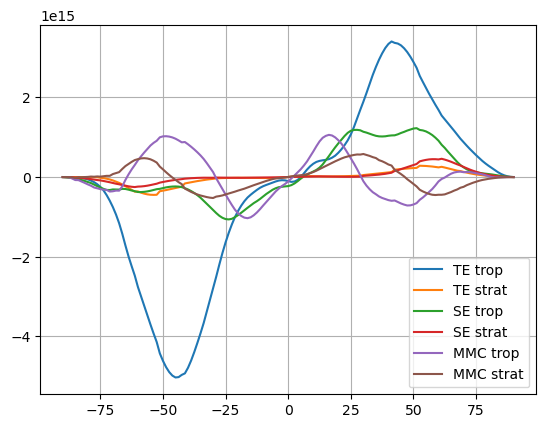

In [154]:
plt.plot(lats, TEs_trop.mean(0) * geometry * g, label='TE trop')
plt.plot(lats, TEs_strat.mean(0) * geometry * g, label='TE strat')

plt.plot(lats, SEs_trop.mean(0) * geometry * g, label='SE trop')
plt.plot(lats, SEs_strat.mean(0) * geometry * g, label='SE strat')

plt.plot(lats, MMCs_trop.mean(0) * geometry * g, label='MMC trop')
plt.plot(lats, MMCs_strat.mean(0) * geometry * g, label='MMC strat')

plt.legend(loc=0)
plt.grid()
plt.show()

In [155]:
TOTs_trop = MMCs_trop + SEs_trop + TEs_trop
TOTs_moist_trop = MMCs_moist_trop + SEs_moist_trop + TEs_moist_trop
TOTs_dry_trop = MMCs_dry_trop + SEs_dry_trop + TEs_dry_trop
TOTs_pot_trop = MMCs_pot_trop + SEs_pot_trop + TEs_pot_trop
TOTs_dry_pot_trop = TOTs_dry_trop + TOTs_pot_trop
TOTs_strat = MMCs_strat + SEs_strat+ TEs_strat
TOTs_moist_strat = MMCs_moist_strat+ SEs_moist_strat + TEs_moist_strat
TOTs_dry_strat = MMCs_dry_strat + SEs_dry_strat + TEs_dry_strat
TOTs_pot_strat = MMCs_pot_strat + SEs_pot_strat + TEs_pot_strat
TOTs_dry_pot_strat = TOTs_dry_strat + TOTs_pot_strat

TEs_dry_pot_trop = TEs_dry_trop + TEs_pot_trop
SEs_dry_pot_trop = SEs_dry_trop + SEs_pot_trop
MMCs_dry_pot_trop = MMCs_dry_trop + MMCs_pot_trop
TEs_dry_pot_strat = TEs_dry_strat + TEs_pot_strat
SEs_dry_pot_strat = SEs_dry_strat + SEs_pot_strat
MMCs_dry_pot_strat = MMCs_dry_strat + MMCs_pot_strat

EDDYs_trop = SEs_trop + TEs_trop
EDDYs_moist_trop = SEs_moist_trop + TEs_moist_trop
EDDYs_dry_trop = SEs_dry_trop + TEs_dry_trop
EDDYs_pot_trop = SEs_pot_trop + TEs_pot_trop
EDDYs_dry_pot_trop = EDDYs_dry_trop + EDDYs_pot_trop
EDDYs_strat= SEs_strat + TEs_strat
EDDYs_moist_strat = SEs_moist_strat + TEs_moist_strat
EDDYs_dry_strat = SEs_dry_strat + TEs_dry_strat
EDDYs_pot_strat = SEs_pot_strat + TEs_pot_strat
EDDYs_dry_pot_strat = EDDYs_dry_strat + EDDYs_pot_strat

In [156]:
final_ds = xr.Dataset(
                    data_vars = dict(
                        total_aht_trop=(['time','latitude'], TOTs_trop * (geometry * g)[None,:]),
                        total_aht_dry_trop=(['time','latitude'], TOTs_dry_trop * (geometry * g)[None,:]),
                        total_aht_moist_trop=(['time','latitude'], TOTs_moist_trop * (geometry * g)[None,:]),
                        total_aht_pot_trop=(['time','latitude'], TOTs_pot_trop * (geometry * g)[None,:]),
                        total_aht_dry_pot_trop=(['time','latitude'], TOTs_dry_pot_trop * (geometry * g)[None,:]),
                        mmc_aht_trop=(['time','latitude'], MMCs_trop * (geometry * g)[None,:]),
                        mmc_aht_dry_trop=(['time','latitude'], MMCs_dry_trop * (geometry * g)[None,:]),
                        mmc_aht_moist_trop=(['time','latitude'], MMCs_moist_trop * (geometry * g)[None,:]),
                        mmc_aht_pot_trop=(['time','latitude'], MMCs_pot_trop * (geometry * g)[None,:]),
                        mmc_aht_dry_pot_trop=(['time','latitude'], MMCs_dry_pot_trop * (geometry * g)[None,:]),
                        se_aht_trop=(['time','latitude'], SEs_trop * (geometry * g)[None,:]),
                        se_aht_dry_trop=(['time','latitude'], SEs_dry_trop * (geometry * g)[None,:]),
                        se_aht_moist_trop=(['time','latitude'], SEs_moist_trop * (geometry * g)[None,:]),
                        se_aht_pot_trop=(['time','latitude'], SEs_pot_trop * (geometry * g)[None,:]),
                        se_aht_dry_pot_trop=(['time','latitude'], SEs_dry_pot_trop * (geometry * g)[None,:]),
                        te_aht_trop=(['time','latitude'], TEs_trop * (geometry * g)[None,:]),
                        te_aht_dry_trop=(['time','latitude'], TEs_dry_trop * (geometry * g)[None,:]),
                        te_aht_moist_trop=(['time','latitude'], TEs_moist_trop * (geometry * g)[None,:]),
                        te_aht_pot_trop=(['time','latitude'], TEs_pot_trop * (geometry * g)[None,:]),
                        te_aht_dry_pot_trop=(['time','latitude'], TEs_dry_pot_trop * (geometry * g)[None,:]),
                        eddy_aht_trop=(['time','latitude'], EDDYs_trop * (geometry * g)[None,:]),
                        eddy_aht_dry_trop=(['time','latitude'], EDDYs_dry_trop * (geometry * g)[None,:]),
                        eddy_aht_moist_trop=(['time','latitude'], EDDYs_moist_trop * (geometry * g)[None,:]),
                        eddy_aht_pot_trop=(['time','latitude'], EDDYs_pot_trop * (geometry * g)[None,:]),
                        eddy_aht_dry_pot_trop=(['time','latitude'], EDDYs_dry_pot_trop * (geometry * g)[None,:]),
                        total_aht_strat=(['time','latitude'], TOTs_strat * (geometry * g)[None,:]),
                        total_aht_dry_strat=(['time','latitude'], TOTs_dry_strat * (geometry * g)[None,:]),
                        total_aht_moist_strat=(['time','latitude'], TOTs_moist_strat * (geometry * g)[None,:]),
                        total_aht_pot_strat=(['time','latitude'], TOTs_pot_strat * (geometry * g)[None,:]),
                        total_aht_dry_pot_strat=(['time','latitude'], TOTs_dry_pot_strat* (geometry * g)[None,:]),
                        mmc_aht_strat=(['time','latitude'], MMCs_strat * (geometry * g)[None,:]),
                        mmc_aht_dry_strat=(['time','latitude'], MMCs_dry_strat * (geometry * g)[None,:]),
                        mmc_aht_moist_strat=(['time','latitude'], MMCs_moist_strat * (geometry * g)[None,:]),
                        mmc_aht_pot_strat=(['time','latitude'], MMCs_pot_strat * (geometry * g)[None,:]),
                        mmc_aht_dry_pot_strat=(['time','latitude'], MMCs_dry_pot_strat * (geometry * g)[None,:]),
                        se_aht_strat=(['time','latitude'], SEs_strat * (geometry * g)[None,:]),
                        se_aht_dry_strat=(['time','latitude'], SEs_dry_strat * (geometry * g)[None,:]),
                        se_aht_moist_strat=(['time','latitude'], SEs_moist_strat * (geometry * g)[None,:]),
                        se_aht_pot_strat=(['time','latitude'], SEs_pot_strat * (geometry * g)[None,:]),
                        se_aht_dry_pot_strat=(['time','latitude'], SEs_dry_pot_strat * (geometry * g)[None,:]),
                        te_aht_strat=(['time','latitude'], TEs_strat * (geometry * g)[None,:]),
                        te_aht_dry_strat=(['time','latitude'], TEs_dry_strat * (geometry * g)[None,:]),
                        te_aht_moist_strat=(['time','latitude'], TEs_moist_strat * (geometry * g)[None,:]),
                        te_aht_pot_strat=(['time','latitude'], TEs_pot_strat * (geometry * g)[None,:]),
                        te_aht_dry_pot_strat=(['time','latitude'], TEs_dry_pot_strat * (geometry * g)[None,:]),
                        eddy_aht_strat=(['time','latitude'], EDDYs_strat * (geometry * g)[None,:]),
                        eddy_aht_dry_strat=(['time','latitude'], EDDYs_dry_strat * (geometry * g)[None,:]),
                        eddy_aht_moist_strat=(['time','latitude'], EDDYs_moist_strat * (geometry * g)[None,:]),
                        eddy_aht_pot_strat=(['time','latitude'], EDDYs_pot_strat * (geometry * g)[None,:]),
                        eddy_aht_dry_pot_strat=(['time','latitude'], EDDYs_dry_pot_strat * (geometry * g)[None,:]),
                        mass=(['time','latitude'], MASSs * (geometry * g)[None,:]),
                        strm_fnct=(['time','level','latitude'], strm_fncts * g * geometry[None,None,:]),
                        VSEse=(['time','level','latitude'], VSEses * 1000 * g**2 * geometry[None,None,:]),
                        VPEse=(['time','level','latitude'], VPEses * 1000 * g**2 * geometry[None,None,:]),
                        VMEse=(['time','level','latitude'], VMEses * 1000 * g**2 * geometry[None,None,:]),
                        VSEte=(['time','level','latitude'], VSEtes * 1000 * g**2 * geometry[None,None,:]),
                        VPEte=(['time','level','latitude'], VPEtes * 1000 * g**2 * geometry[None,None,:]),
                        VMEte=(['time','level','latitude'], VMEtes * 1000 * g**2 * geometry[None,None,:]),
                        V_bar=(['time','level','latitude'], V_bars),
                        E_bar=(['time','level','latitude'], E_bars),
                        ME_bar=(['time','level','latitude'], ME_bars),
                        PE_bar=(['time','level','latitude'], PE_bars),
                        SE_bar=(['time','level','latitude'], SE_bars),
                    ),
                    coords=dict(
                        time=jra_data.time,
                        level=levels,
                        latitude=lats,)
)

#final_ds.to_netcdf('jra_aht_trop_strat_split_new.nc')

In [157]:
#orig_ds = xr.open_dataset('jra_aht_trop_strat_split.nc')
orig_ds = xr.open_dataset('jra_aht.nc')
#final_ds = xr.open_dataset('jra_aht_trop_strat_split_new.nc')

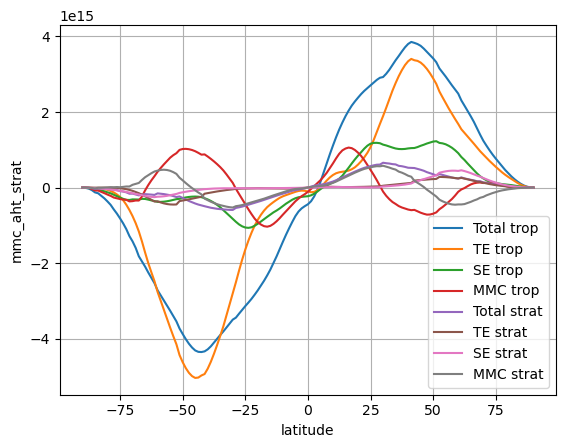

In [169]:
(final_ds.total_aht_trop.mean('time')).plot(label='Total trop')
(final_ds.te_aht_trop.mean('time')).plot(label='TE trop')
(final_ds.se_aht_trop.mean('time')).plot(label='SE trop')
(final_ds.mmc_aht_trop.mean('time')).plot(label='MMC trop')

(final_ds.total_aht_strat.mean('time')).plot(label='Total strat')
(final_ds.te_aht_strat.mean('time')).plot(label='TE strat')
(final_ds.se_aht_strat.mean('time')).plot(label='SE strat')
(final_ds.mmc_aht_strat.mean('time')).plot(label='MMC strat')

plt.grid()

plt.legend(loc=0)

plt.show()

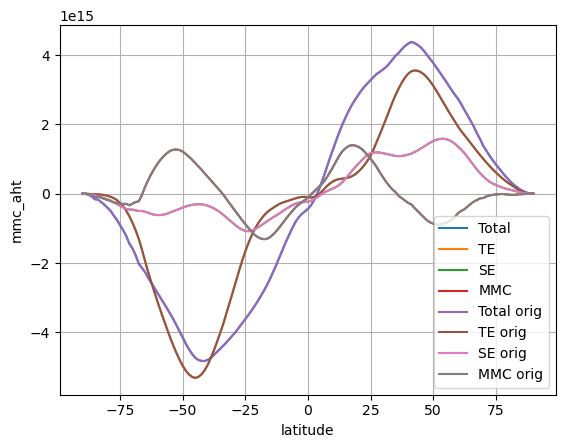

In [170]:
((final_ds.total_aht_trop + final_ds.total_aht_strat).mean('time')).plot(label='Total')
((final_ds.te_aht_trop + final_ds.te_aht_strat).mean('time')).plot(label='TE')
((final_ds.se_aht_trop + final_ds.se_aht_strat).mean('time')).plot(label='SE')
((final_ds.mmc_aht_trop + final_ds.mmc_aht_strat).mean('time')).plot(label='MMC')

(orig_ds.total_aht.mean('time')).plot(label='Total orig')
(orig_ds.te_aht.mean('time')).plot(label='TE orig')
(orig_ds.se_aht.mean('time')).plot(label='SE orig')
(orig_ds.mmc_aht.mean('time')).plot(label='MMC orig')

plt.grid()

plt.legend(loc=0)

plt.show()

1.243255409665647
0.1381755708007686


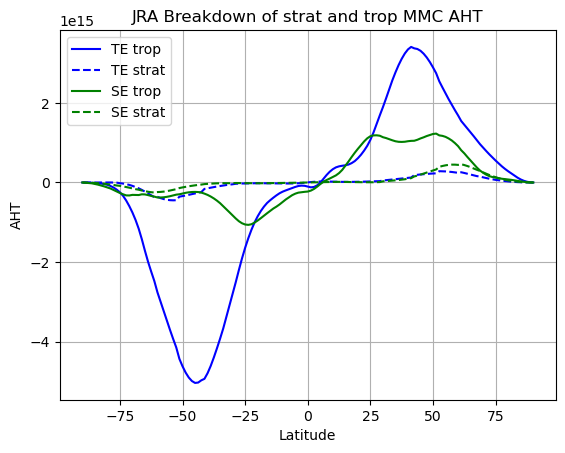

In [230]:
(final_ds.te_aht_trop.mean('time')).plot(color='b', label='TE trop')
(final_ds.te_aht_strat.mean('time')).plot(linestyle='--', color='b', label='TE strat')
(final_ds.se_aht_trop.mean('time')).plot(color='g', label='SE trop')
(final_ds.se_aht_strat.mean('time')).plot(linestyle='--', color='g', label='SE strat')


print(final_ds.total_aht_trop.mean('time').sel(latitude=70).values / 1e15)
print(final_ds.total_aht_strat.mean('time').sel(latitude=70).values / 1e15)

plt.legend(loc=0)
plt.grid()

plt.xlabel('Latitude')
plt.ylabel('AHT')
plt.title('JRA Breakdown of strat and trop MMC AHT')

#plt.savefig('../figures/Nov_22/mmc_strat_trop_breakdown')
plt.show()

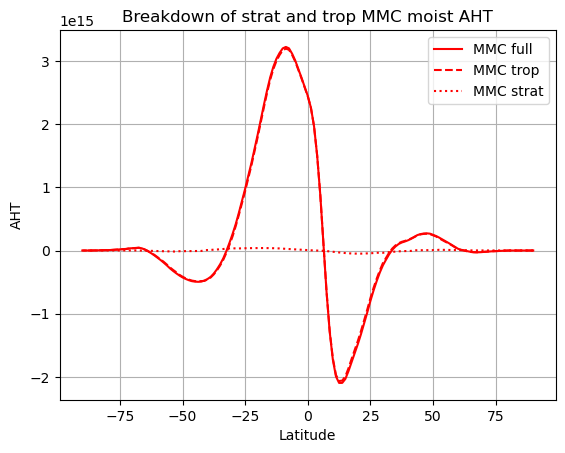

In [249]:
#(final_ds.te_aht_trop.mean('time')).plot(color='b', label='TE trop')
#(final_ds.te_aht_strat.mean('time')).plot(linestyle='--', color='b', label='TE strat')
#(final_ds.se_aht_trop.mean('time')).plot(color='g', label='SE trop')
#(final_ds.se_aht_strat.mean('time')).plot(linestyle='--', color='g', label='SE strat')

(orig_ds.mmc_aht_moist.mean('time')).plot(color='r', label='MMC full')
(final_ds.mmc_aht_moist_trop.mean('time')).plot(linestyle='--', color='r', label='MMC trop')
(final_ds.mmc_aht_moist_strat.mean('time')).plot(linestyle=':', color='r', label='MMC strat')
#((final_ds.mmc_aht_dry_strat + final_ds.mmc_aht_moist_strat + final_ds.mmc_aht_pot_strat).mean('time')).plot(linestyle='-.', color='r', label='MMC strat sum')
#print(final_ds.total_aht_trop.mean('time').sel(latitude=70).values / 1e15)
#print(final_ds.total_aht_strat.mean('time').sel(latitude=70).values / 1e15)

plt.legend(loc=0)
plt.grid()

plt.xlabel('Latitude')
plt.ylabel('AHT')
plt.title('Breakdown of strat and trop MMC moist AHT')

#plt.savefig('../figures/Nov_22/mmc_moist_strat_trop_breakdown')
plt.show()

In [220]:
merra_data = xr.open_mfdataset('../merra_data/raw_data/MERRA2_*')

#Let's only select through 2021, the last full year
merra_data = merra_data.sel(time=slice('1980-01-01', '2021-12-31'))

merra_data

<xarray.Dataset>
Dimensions:   (time: 504, lat: 361, lon: 576, lev: 42)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lev       (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.5 0.4 0.3 0.1
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2021-12-01
Data variables:
    PS        (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    Cov_V_T   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    V         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    T         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    Cov_V_H   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    QV        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    Cov_V_QV  (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    H         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    History:                           Original file generated: Thu May  7 22...
    Filename:                          MERRA2_100.instM_3d_asm_Np.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.inst3_3d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/2E096JV59PK7
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   21:00:00.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2022-09-29 15:28:15 GMT Hyrax-1.16.3 h...

In [222]:
vcomp_mean_merra = merra_data.V.mean(['time', 'lon']).compute()
height_mean_merra = merra_data.H.mean(['time', 'lon']).compute()

In [208]:
vcomp_mean = jra_data.vcomp.mean(['time', 'lon']).compute()
height_mean = jra_data.height.mean(['time', 'lon']).compute()

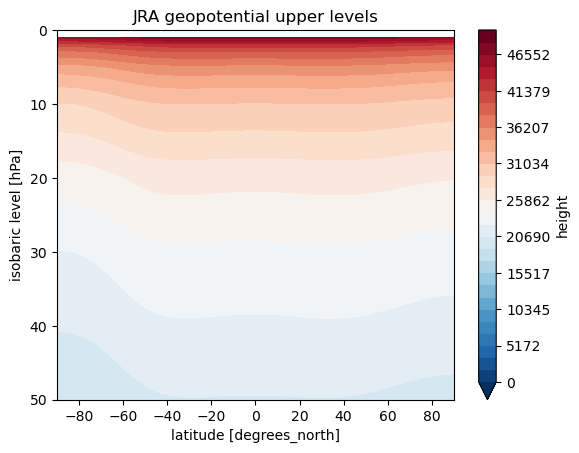

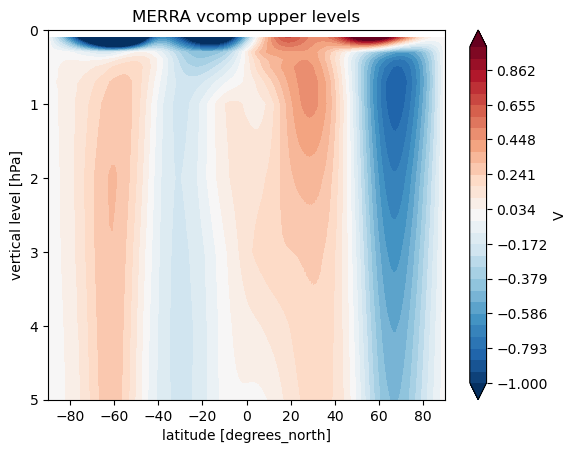

In [260]:
#vcomp_mean.plot.contourf(levels=np.linspace(-1, 1, 30))
height_mean.plot.contourf(levels=np.linspace(0, 50000, 30))

plt.ylim([0, 50])
#plt.ylim([900, 1000])   
plt.gca().invert_yaxis()

plt.title('JRA geopotential upper levels')

#plt.savefig('../figures/Nov_22/jra_height_stratosphere')
plt.show()

vcomp_mean_merra.plot.contourf(levels=np.linspace(-1, 1, 30))
#height_mean_merra.plot.contourf(levels=np.linspace(0, 100000, 30))

plt.ylim([0, 5])
#plt.ylim([900, 1000])   
plt.gca().invert_yaxis()
plt.title('MERRA vcomp upper levels')

#plt.savefig('../figures/Nov_22/merra_vcomp_stratosphere')
plt.show()

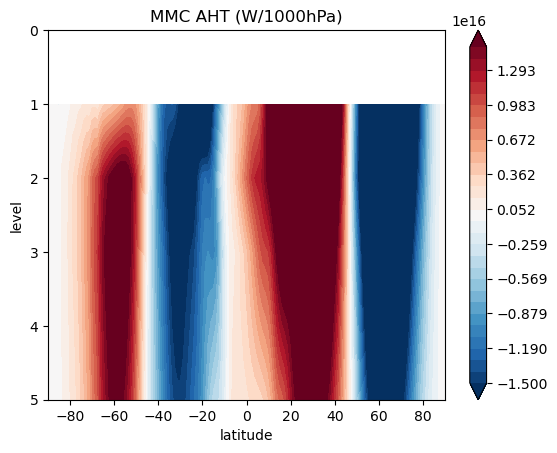

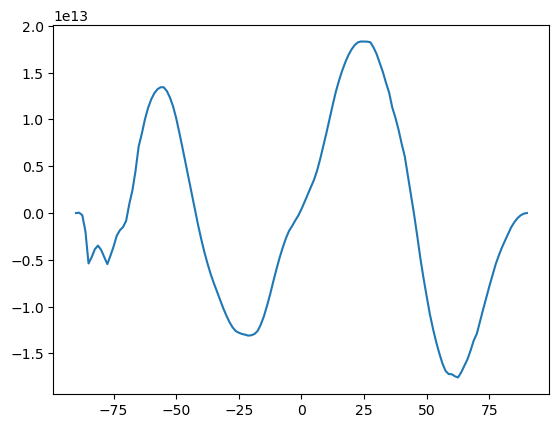

In [261]:
mmc_vert = final_ds.V_bar * final_ds.E_bar# * ZON_WEIGHT[None,:,:]

#(g * geometry[None,:] * mmc_vert.mean('time')).plot.contourf()

(g**2 * 1000 * geometry[None,:] * mmc_vert.mean('time')).plot.contourf(levels=np.linspace(-15e15, 15e15, 30))
#(mmc_vert.mean('time')).plot.contourf(levels=np.linspace(-1, 1, 30))
#(mmc_vert.mean('time')).plot.contourf(levels=np.linspace(-1000000, 1000000, 30))

plt.ylim([0, 5])
plt.title('MMC AHT (W/1000hPa)') 
plt.gca().invert_yaxis()

#plt.savefig('../figures/Nov_22/jra_mmc_aht_vert_strat')
plt.show()

plt.plot(final_ds.latitude, np.sum(mmc_vert.mean('time'), axis=(0)) * g * geometry)
plt.show()

In [174]:
trends_ds = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
orig_trends = orig_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

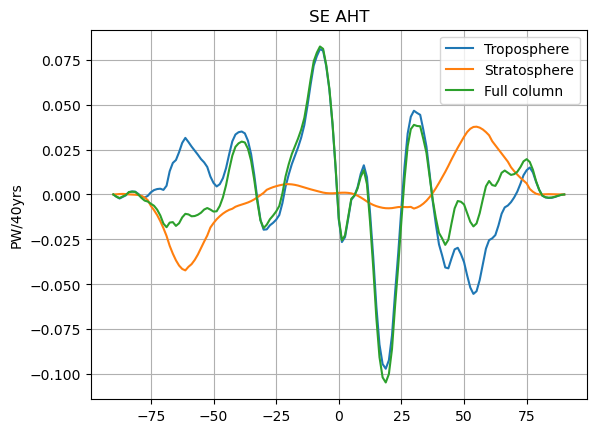

In [287]:
plt.plot(lats, (trends_ds.se_aht_trop_polyfit_coefficients.sel(degree=1) * 40)/1e15, label='Troposphere')
plt.plot(lats, (trends_ds.se_aht_strat_polyfit_coefficients.sel(degree=1) * 40)/1e15, label='Stratosphere')
plt.plot(lats, (orig_trends.se_aht_polyfit_coefficients.sel(degree=1) * 40)/1e15, label='Full column')

plt.legend(loc=0)
plt.title('SE AHT')
plt.ylabel('PW/40yrs')
plt.grid()
#plt.savefig('../figures/Nov_22/se_aht_trop_strat_trends')
plt.show()

In [176]:
def trend(x):
    return x.polyfit('time', deg=1)

jra_month = final_ds.groupby('time.month').mean('time')

#Output is in W/ns, so we convert to PW/40yrs
jra_trends_month = final_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15

jra_orig_month = orig_ds.groupby('time.month').mean('time')

#Output is in W/ns, so we convert to PW/40yrs
jra_orig_trends_month = orig_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40 / 1e15

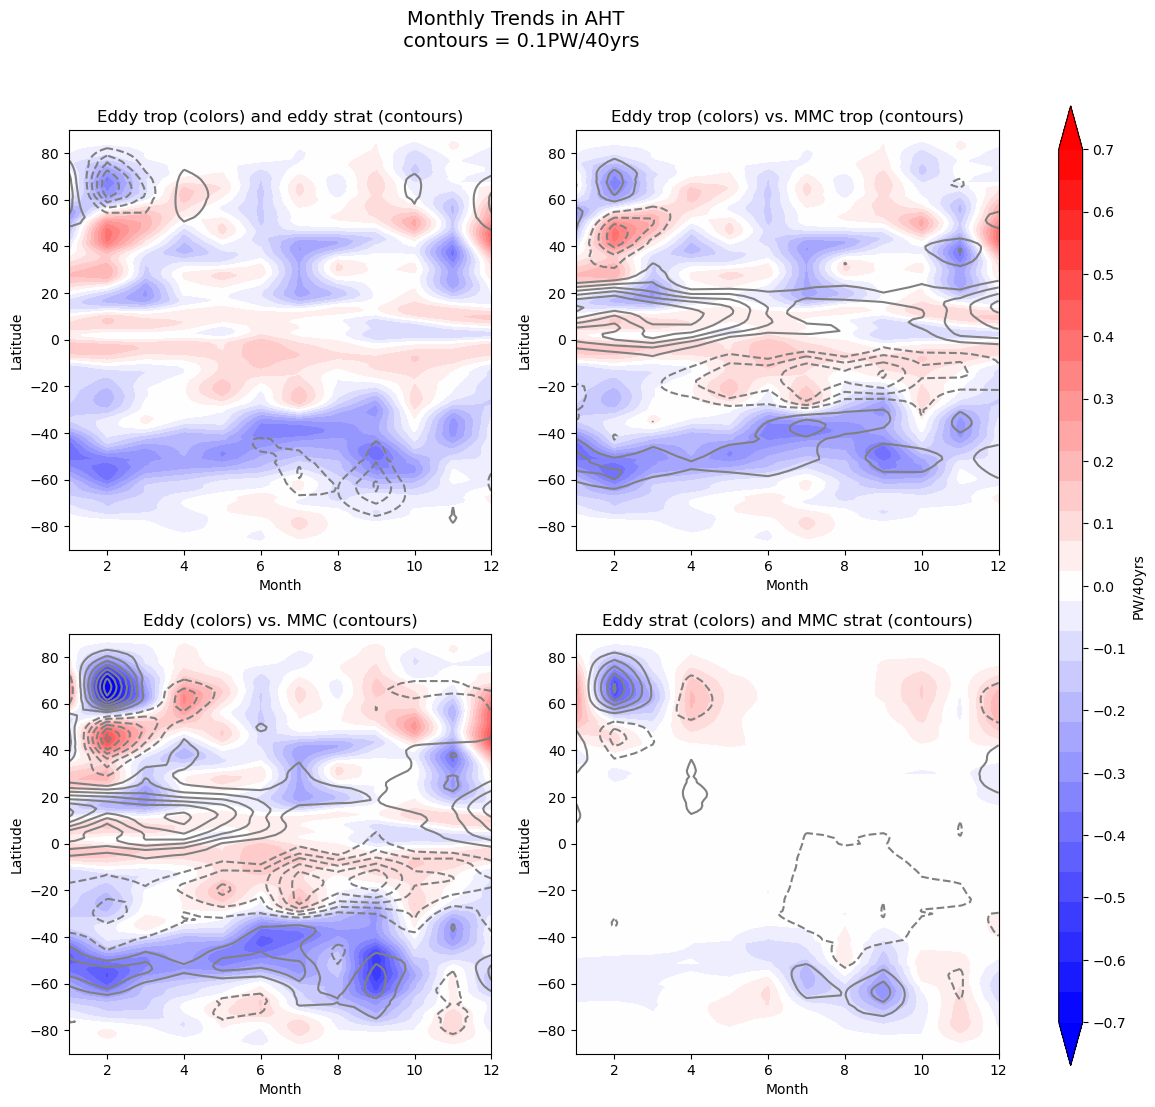

In [289]:
mmc_levels = [-0.7, -0.6, -0.5, -.4, -.3, -0.2, -0.1, 0.1, 0.2, .3, .4, .5, .6, .7]

eddy_levels = np.linspace(-0.7, 0.7, 30)

fig, axs = plt.subplots(2,2, figsize=(12, 12))

axs[0,0].contour(range(1,13), lats, jra_trends_month.eddy_aht_strat_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels,  colors='grey')

axs[0,0].contourf(range(1,13), lats, (jra_trends_month.eddy_aht_trop_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#axs[0,0].contour(range(1,13), lats, (jra_trends_month.eddy_aht_trop_polyfit_coefficients).sel(degree=1).T,
             #levels=eddy_levels,  cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,0].set_title('Eddy trop (colors) and eddy strat (contours)')
axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Latitude')
#plt.show()

axs[1,0].contour(range(1,13), lats, jra_orig_trends_month.mmc_aht_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels, colors='grey')

axs[1,0].contourf(range(1,13), lats, (jra_orig_trends_month.eddy_aht_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar()
axs[1,0].set_title('Eddy (colors) vs. MMC (contours)')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Latitude')
#plt.show()

axs[0,1].contour(range(1,13), lats, jra_trends_month.mmc_aht_trop_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels, colors='grey')

axs[0,1].contourf(range(1,13), lats, (jra_trends_month.eddy_aht_trop_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar()
axs[0,1].set_title('Eddy trop (colors) vs. MMC trop (contours)')
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('Latitude')
#plt.show()

axs[1,1].contour(range(1,13), lats, jra_trends_month.mmc_aht_strat_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels, colors='grey')

eddy_plt = axs[1,1].contourf(range(1,13), lats, (jra_trends_month.eddy_aht_strat_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar()
axs[1,1].set_title('Eddy strat (colors) and MMC strat (contours)')
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Latitude')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(eddy_plt, cax=cbar_ax, ticks=np.arange(-0.7, 0.8, .1), label='PW/40yrs')

fig.suptitle('Monthly Trends in AHT \n contours = 0.1PW/40yrs',fontsize=14)

#plt.savefig('../figures/Nov_22/strat_trop_eddy_mmc_monthly_trends', bbox_inches = "tight")
plt.show()

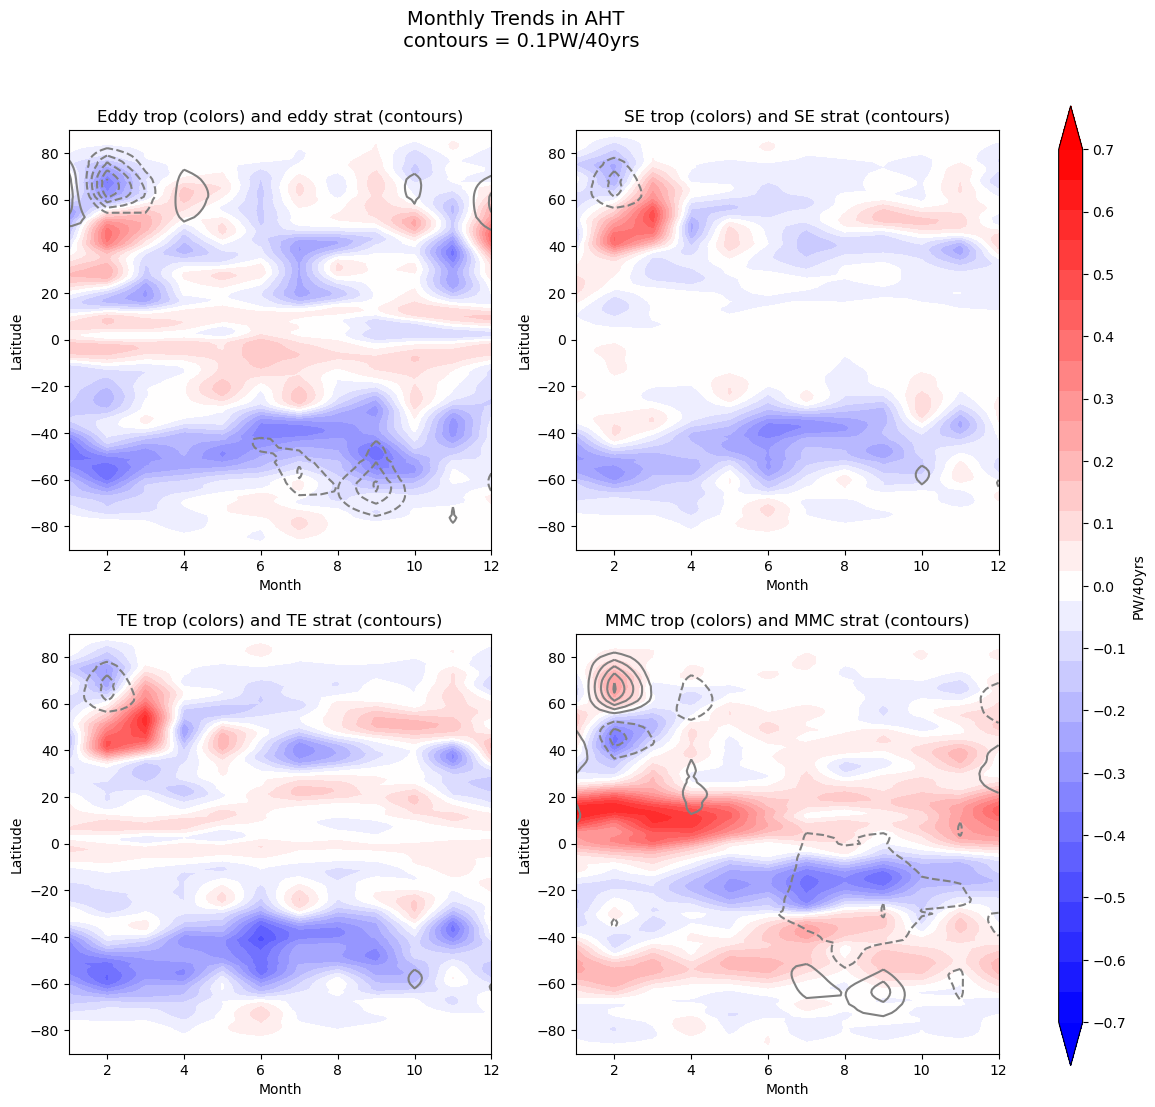

In [293]:
mmc_levels = [-0.7, -0.6, -0.5, -.4, -.3, -0.2, -0.1, 0.1, 0.2, .3, .4, .5, .6, .7]

eddy_levels = np.linspace(-0.7, 0.7, 30)

fig, axs = plt.subplots(2,2, figsize=(12, 12))

axs[0,0].contour(range(1,13), lats, jra_trends_month.eddy_aht_strat_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels,  colors='grey')

axs[0,0].contourf(range(1,13), lats, (jra_trends_month.eddy_aht_trop_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#axs[0,0].contour(range(1,13), lats, (jra_trends_month.eddy_aht_trop_polyfit_coefficients).sel(degree=1).T,
             #levels=eddy_levels,  cmap='bwr')

#plt.colorbar(label='PW/40yrs')
axs[0,0].set_title('Eddy trop (colors) and eddy strat (contours)')
axs[0,0].set_xlabel('Month')
axs[0,0].set_ylabel('Latitude')
#plt.show()

axs[1,0].contour(range(1,13), lats, jra_trends_month.te_aht_strat_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels, colors='grey')

axs[1,0].contourf(range(1,13), lats, (jra_trends_month.te_aht_trop_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar()
axs[1,0].set_title('TE trop (colors) and TE strat (contours)')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Latitude')
#plt.show()

axs[0,1].contour(range(1,13), lats, jra_trends_month.te_aht_dry_pot_strat_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels, colors='grey')

axs[0,1].contourf(range(1,13), lats, (jra_trends_month.te_aht_dry_pot_trop_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar()
axs[0,1].set_title('SE trop (colors) and SE strat (contours)')
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('Latitude')
#plt.show()

axs[1,1].contour(range(1,13), lats, jra_trends_month.mmc_aht_strat_polyfit_coefficients.sel(degree=1).T,
             levels=mmc_levels, colors='grey')

eddy_plt = axs[1,1].contourf(range(1,13), lats, (jra_trends_month.mmc_aht_trop_polyfit_coefficients).sel(degree=1).T,
             levels=eddy_levels, extend='both', cmap='bwr')

#plt.colorbar()
axs[1,1].set_title('MMC trop (colors) and MMC strat (contours)')
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Latitude')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(eddy_plt, cax=cbar_ax, ticks=np.arange(-0.7, 0.8, .1), label='PW/40yrs')

fig.suptitle('Monthly Trends in AHT \n contours = 0.1PW/40yrs',fontsize=14)

#plt.savefig('../figures/Nov_22/strat_trop_aht_component_split_monthly_trends', bbox_inches = "tight")
plt.show()

In [178]:
def detrend_std(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    
    no_trend = da - fit
    
    stdized = (no_trend.groupby('time.month') - no_trend.groupby('time.month').mean('time')).drop('month') / no_trend.std('time')
    return stdized

def deseason(da, dim='time', deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    
    no_trend = da - fit
    
    stdized = (no_trend.groupby('time.month') - no_trend.groupby('time.month').mean('time')).drop('month')
    return stdized


te_trop_no_trend = detrend_std(final_ds.te_aht_trop, dim='time')
te_strat_no_trend = detrend_std(final_ds.te_aht_strat, dim='time')

se_trop_no_trend = detrend_std(final_ds.se_aht_trop, dim='time')
se_strat_no_trend = detrend_std(final_ds.se_aht_strat, dim='time')

eddy_trop_no_trend = detrend_std(final_ds.eddy_aht_trop, dim='time')
eddy_strat_no_trend = detrend_std(final_ds.eddy_aht_strat, dim='time')

mmc_trop_no_trend = detrend_std(final_ds.mmc_aht_trop, dim='time')
mmc_strat_no_trend = detrend_std(final_ds.mmc_aht_strat, dim='time')

te_full_no_trend = detrend_std(orig_ds.te_aht, dim='time')
se_full_no_trend = detrend_std(orig_ds.se_aht, dim='time')
eddy_full_no_trend = detrend_std(orig_ds.eddy_aht, dim='time')
mmc_full_no_trend = detrend_std(orig_ds.mmc_aht, dim='time')


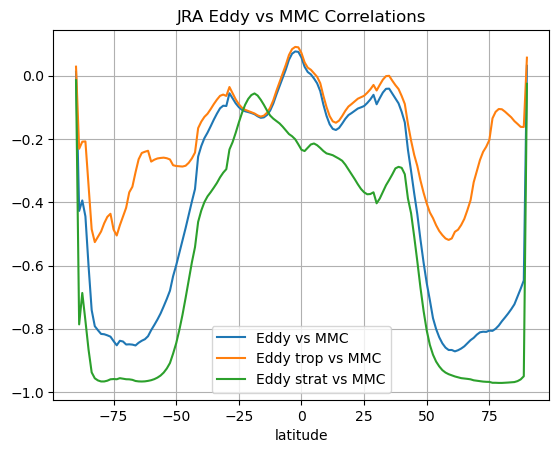

In [254]:
eddy_mmc_corr = xr.corr(eddy_full_no_trend, mmc_full_no_trend, dim='time')
eddy_mmc_trop_corr = xr.corr(eddy_full_no_trend, mmc_trop_no_trend, dim='time')

mmc_trop_mmc_strat_corr = xr.corr(mmc_strat_no_trend, mmc_trop_no_trend, dim='time')
eddy_trop_eddy_strat_corr = xr.corr(eddy_strat_no_trend, eddy_trop_no_trend, dim='time')

eddy_trop_mmc_corr = xr.corr(eddy_trop_no_trend, mmc_full_no_trend, dim='time')
eddy_strat_mmc_corr = xr.corr(eddy_strat_no_trend, mmc_full_no_trend, dim='time')

eddy_trop_mmc_trop_corr = xr.corr(eddy_trop_no_trend, mmc_trop_no_trend, dim='time')
eddy_strat_mmc_trop_corr = xr.corr(eddy_strat_no_trend, mmc_trop_no_trend, dim='time')

eddy_mmc_strat_corr = xr.corr(eddy_full_no_trend, mmc_strat_no_trend, dim='time')
eddy_trop_mmc_strat_corr = xr.corr(eddy_trop_no_trend, mmc_strat_no_trend, dim='time')
eddy_strat_mmc_strat_corr = xr.corr(eddy_strat_no_trend, mmc_strat_no_trend, dim='time')

eddy_mmc_strat_corr.plot(label='Eddy vs MMC')
eddy_trop_mmc_strat_corr.plot(label='Eddy trop vs MMC')
eddy_strat_mmc_strat_corr.plot(label='Eddy strat vs MMC')

#eddy_trop_mmc_trop_corr.plot(label='Eddy trop MMC trop')
#eddy_strat_mmc_trop_corr.plot(label='Eddy strat MMC trop')

#eddy_trop_mmc_strat_corr.plot(label='Eddy trop MMC strat')
#eddy_strat_mmc_strat_corr.plot(label='Eddy strat MMC strat')

#mmc_trop_mmc_strat_corr.plot(label='MMC trop vs strat')
#eddy_trop_eddy_strat_corr.plot(label='Eddy trop vs strat')

plt.legend(loc=0)
plt.grid()
plt.title('JRA Eddy vs MMC Correlations')
#plt.savefig('../figures/Nov_22/jra_mmc_and_eddy_trop_strat_corrs')
plt.show()

In [180]:
eddy_mmc_slope = np.zeros(len(lats))
eddy_trop_mmc_slope = np.zeros(len(lats))
eddy_strat_mmc_slope = np.zeros(len(lats))

eddy_mmc_trop_slope = np.zeros(len(lats))
eddy_trop_mmc_trop_slope = np.zeros(len(lats))
eddy_strat_mmc_trop_slope = np.zeros(len(lats))

eddy_mmc_strat_slope = np.zeros(len(lats))
eddy_trop_mmc_strat_slope = np.zeros(len(lats))
eddy_strat_mmc_strat_slope = np.zeros(len(lats))

for i in range(len(lats)):

    eddy_mmc_slope[i] = np.polyfit(deseason(orig_ds.eddy_aht[:,i]), deseason(orig_ds.mmc_aht[:,i]), deg=1)[0]
    eddy_trop_mmc_slope[i] = np.polyfit(deseason(final_ds.eddy_aht_trop[:,i]), deseason(orig_ds.mmc_aht[:,i]), deg=1)[0]
    eddy_strat_mmc_slope[i] = np.polyfit(deseason(final_ds.eddy_aht_strat[:,i]), deseason(orig_ds.mmc_aht[:,i]), deg=1)[0]
    
    eddy_mmc_trop_slope[i] = np.polyfit(deseason(orig_ds.eddy_aht[:,i]), deseason(final_ds.mmc_aht_trop[:,i]), deg=1)[0]
    eddy_trop_mmc_trop_slope[i] = np.polyfit(deseason(final_ds.eddy_aht_trop[:,i]), deseason(final_ds.mmc_aht_trop[:,i]), deg=1)[0]
    eddy_strat_mmc_trop_slope[i] = np.polyfit(deseason(final_ds.eddy_aht_strat[:,i]), deseason(final_ds.mmc_aht_trop[:,i]), deg=1)[0]
    
    eddy_mmc_strat_slope[i] = np.polyfit(deseason(orig_ds.eddy_aht[:,i]), deseason(final_ds.mmc_aht_strat[:,i]), deg=1)[0]
    eddy_trop_mmc_strat_slope[i] = np.polyfit(deseason(final_ds.eddy_aht_trop[:,i]), deseason(final_ds.mmc_aht_strat[:,i]), deg=1)[0]
    eddy_strat_mmc_strat_slope[i] = np.polyfit(deseason(final_ds.eddy_aht_strat[:,i]), deseason(final_ds.mmc_aht_strat[:,i]), deg=1)[0]
    

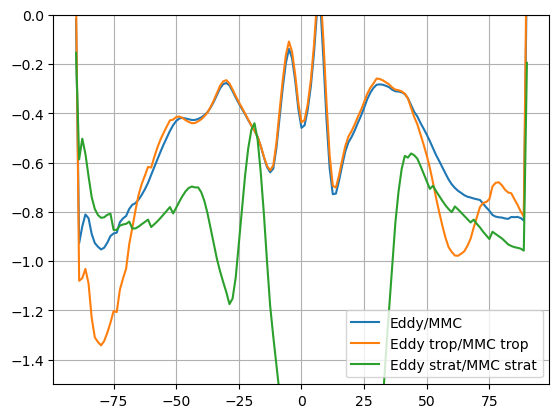

In [256]:
plt.plot(lats, eddy_mmc_slope, label='Eddy/MMC')
plt.plot(lats, eddy_trop_mmc_slope, label='Eddy trop/MMC trop')
plt.plot(lats, eddy_strat_mmc_strat_slope, label='Eddy strat/MMC strat')

#plt.plot(lats, eddy_mmc_trop_slope, label='Eddy/MMC trop')
#plt.plot(lats, eddy_trop_mmc_trop_slope, label='Eddy trop/MMC trop')
#plt.plot(lats, eddy_strat_mmc_trop_slope, label='Eddy strat/MMC trop')

#plt.plot(lats, eddy_mmc_strat_slope, label='Eddy/MMC strat')
#plt.plot(lats, eddy_trop_mmc_strat_slope, label='Eddy trop/MMC strat')
#plt.plot(lats, eddy_strat_mmc_strat_slope, label='Eddy strat/MMC strat')

plt.grid()
plt.ylim([-1.5, 0])
plt.legend(loc=0)
plt.show()

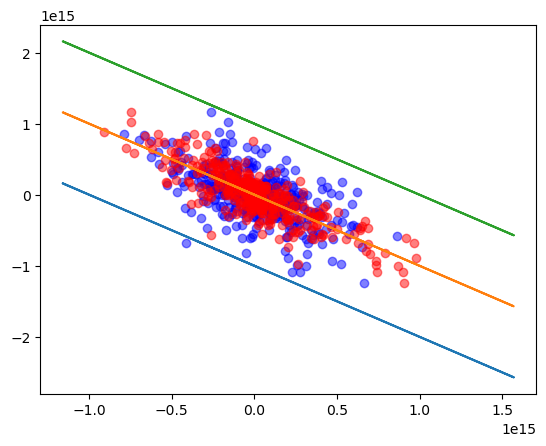

In [182]:
which_lat = 70

#plt.scatter(eddy_full_no_trend.sel(latitude=which_lat), mmc_full_no_trend.sel(latitude=which_lat))
plt.scatter(deseason(final_ds.eddy_aht_trop.sel(latitude=which_lat)), deseason(orig_ds.mmc_aht.sel(latitude=which_lat)), alpha=0.5, color='b')
plt.scatter(deseason(final_ds.eddy_aht_strat.sel(latitude=which_lat)), deseason(orig_ds.mmc_aht.sel(latitude=which_lat)), alpha=0.5, color='r')

for i in range(-1, 2):
    plt.plot(deseason(orig_ds.eddy_aht.sel(latitude=which_lat)), (i * 1e15) - deseason(orig_ds.eddy_aht.sel(latitude=which_lat)))
plt.show()